# Load Packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install extra packages needed for this notebook
!pip install -q pyunpack patool rarfile rioxarray

# --- Imports ---

import os
import sys
import pathlib
import requests

import numpy as np
import pandas as pd
import glob
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling
from rasterio.windows import Window
import PIL
from PIL import Image

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import *
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import pyunpack
from rarfile import RarFile
import rioxarray as rxr

from sklearn.metrics import *

from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, Conv2DTranspose, MaxPooling2D,
    Dropout, BatchNormalization, Activation, UpSampling2D,
    concatenate, add, multiply,
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K






   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.2 MB/s eta 0:00:00


In [3]:
# --- 0. Setup: imports & paths ---

# Folder where GEE exports were saved
GEE_DIR = '/content/drive/MyDrive/GEE_Iraq'

# Where to save tiles
OUT_IMG_DIR = '/content/tiles/images'
OUT_MSK_DIR = '/content/tiles/masks'

os.makedirs(OUT_IMG_DIR, exist_ok=True)
os.makedirs(OUT_MSK_DIR, exist_ok=True)

TILE_SIZE = 256   # UNet input tile size
MIN_WATER_PIXELS = 50  # skip almost-all-land tiles (adjust as you like)



In [4]:
def align_mask_to_image(img_path, mask_path):
    """
    Returns (img_arr, mask_arr, profile) where:
      img_arr:  (H, W, 4)
      mask_arr: (H, W) with values 0/1
    """
    with rasterio.open(img_path) as src_img:
        img = src_img.read()  # (bands, H, W)
        img_profile = src_img.profile

    with rasterio.open(mask_path) as src_msk:
        msk = src_msk.read(1)  # (H2, W2)

        # If shapes + transforms match, no reprojection needed
        if (src_msk.transform == img_profile['transform'] and
            src_msk.width == img_profile['width'] and
            src_msk.height == img_profile['height']):
            mask_resampled = msk
        else:
            # Reproject to match image grid
            mask_resampled = np.zeros((img_profile['height'], img_profile['width']), dtype=np.float32)

            reproject(
                source=msk,
                destination=mask_resampled,
                src_transform=src_msk.transform,
                src_crs=src_msk.crs,
                dst_transform=img_profile['transform'],
                dst_crs=img_profile['crs'],
                resampling=Resampling.nearest
            )

    # Move image channels last: (bands, H, W) -> (H, W, bands)
    img_arr = np.transpose(img, (1, 2, 0)).astype(np.float32)

    # Ensure mask is 0/1
    mask_arr = (mask_resampled > 0.5).astype(np.uint8)

    return img_arr, mask_arr, img_profile


In [5]:
def tile_image_and_mask(img_arr, mask_arr, base_name,
                        tile_size=TILE_SIZE,
                        min_water_pixels=MIN_WATER_PIXELS):
    """
    Cuts image & mask into tiles, saves non-empty ones as .npy.
    """
    H, W, C = img_arr.shape
    tile_id = 0

    for row in range(0, H, tile_size):
        for col in range(0, W, tile_size):
            if row + tile_size > H or col + tile_size > W:
                continue  # skip incomplete edge tiles (optional)

            img_tile = img_arr[row:row+tile_size, col:col+tile_size, :]
            msk_tile = mask_arr[row:row+tile_size, col:col+tile_size]

            # Skip tiles with almost no water
            if msk_tile.sum() < min_water_pixels:
                continue

            img_out_path = os.path.join(
                OUT_IMG_DIR, f"{base_name}_tile_{tile_id:04d}.npy"
            )
            msk_out_path = os.path.join(
                OUT_MSK_DIR, f"{base_name}_tile_{tile_id:04d}.npy"
            )

            np.save(img_out_path, img_tile)
            np.save(msk_out_path, msk_tile)

            tile_id += 1

    print(f"{base_name}: saved {tile_id} tiles.")


In [6]:
# Find all S2 images
s2_files = sorted(glob.glob(os.path.join(GEE_DIR, '*_s2_4band.tif')))

for s2_path in s2_files:
    base = os.path.basename(s2_path).replace('_s2_4band.tif', '')
    mask_path = os.path.join(GEE_DIR, base + '_gsw_water.tif')

    if not os.path.exists(mask_path):
        print(f"⚠️ No mask for {base}, skipping.")
        continue

    print(f"Processing {base}...")

    img_arr, mask_arr, profile = align_mask_to_image(s2_path, mask_path)

    # Simple normalisation (optional – adjust to your UNet)
    # Example: Sentinel-2 often scaled by 10,000
    img_arr = img_arr / 3000.0  # or 10000.0 depending on stretch

    tile_image_and_mask(img_arr, mask_arr, base)


Processing Dukan_2017...
Dukan_2017: saved 74 tiles.
Processing Dukan_2021...
Dukan_2021: saved 91 tiles.
Processing Habbaniyah_2017...
Habbaniyah_2017: saved 149 tiles.
Processing Habbaniyah_2021...
Habbaniyah_2021: saved 136 tiles.
Processing Razzaza_2017...
Razzaza_2017: saved 250 tiles.
Processing Razzaza_2021...
Razzaza_2021: saved 247 tiles.
Processing darbandikhan_2017...
darbandikhan_2017: saved 14 tiles.
Processing darbandikhan_2021...
darbandikhan_2021: saved 55 tiles.
Processing tharthar_2017...
tharthar_2017: saved 285 tiles.
Processing tharthar_2021...
tharthar_2021: saved 239 tiles.


In [7]:
def align_mask_to_image(img_path, mask_path):
    """
    Returns cleaned:
      img_arr: (H, W, 4)
      mask_arr: (H, W)
    """
    import rasterio
    import numpy as np
    from rasterio.warp import reproject, Resampling

    # ---- READ IMAGE ----
    with rasterio.open(img_path) as src_img:
        img = src_img.read().astype('float32')   # (bands, H, W)
        img_profile = src_img.profile

    # ---- CLEAN IMAGE ----
    img = np.nan_to_num(img, nan=0.0, posinf=0.0, neginf=0.0)

    # ---- READ MASK ----
    with rasterio.open(mask_path) as src_msk:
        msk = src_msk.read(1).astype('float32')

        # CLEAN MASK
        msk = np.nan_to_num(msk, nan=0.0)

        # If shapes match, no reprojection needed
        if (src_msk.transform == img_profile['transform'] and
            src_msk.width == img_profile['width'] and
            src_msk.height == img_profile['height']):
            mask_resampled = msk
        else:
            # Reproject to image grid
            mask_resampled = np.zeros((img_profile['height'], img_profile['width']),
                                      dtype='float32')

            reproject(
                source=msk,
                destination=mask_resampled,
                src_transform=src_msk.transform,
                src_crs=src_msk.crs,
                dst_transform=img_profile['transform'],
                dst_crs=img_profile['crs'],
                resampling=Resampling.nearest
            )

    # Move channels last
    img_arr = np.transpose(img, (1,2,0))   # (H, W, 4)

    # Ensure mask is 0/1
    mask_arr = (mask_resampled > 0.5).astype(np.uint8)

    return img_arr, mask_arr, img_profile


In [8]:
for s2_path in s2_files:
    base = os.path.basename(s2_path).replace('_s2_4band.tif', '')
    mask_path = os.path.join(GEE_DIR, base + '_gsw_water.tif')

    if not os.path.exists(mask_path):
        print(f"⚠ No mask for {base}, skipping")
        continue

    print(f"Processing {base}...")

    img_arr, mask_arr, profile = align_mask_to_image(s2_path, mask_path)

    # DO NOT NORMALISE HERE
    tile_image_and_mask(img_arr, mask_arr, base)


Processing Dukan_2017...
Dukan_2017: saved 74 tiles.
Processing Dukan_2021...
Dukan_2021: saved 91 tiles.
Processing Habbaniyah_2017...
Habbaniyah_2017: saved 149 tiles.
Processing Habbaniyah_2021...
Habbaniyah_2021: saved 136 tiles.
Processing Razzaza_2017...
Razzaza_2017: saved 250 tiles.
Processing Razzaza_2021...
Razzaza_2021: saved 247 tiles.
Processing darbandikhan_2017...
darbandikhan_2017: saved 14 tiles.
Processing darbandikhan_2021...
darbandikhan_2021: saved 55 tiles.
Processing tharthar_2017...
tharthar_2017: saved 285 tiles.
Processing tharthar_2021...
tharthar_2021: saved 239 tiles.


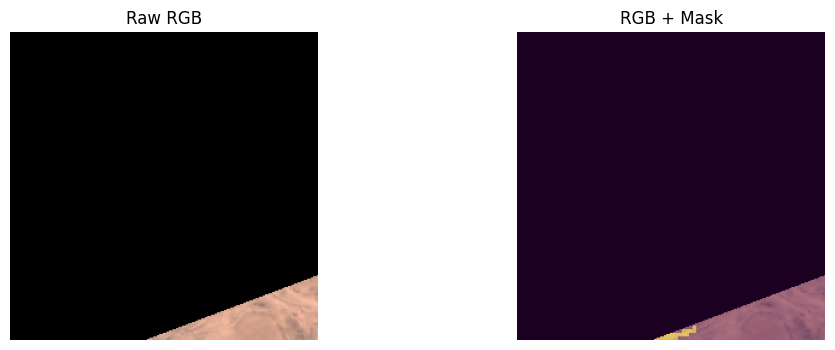

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import glob, os

OUT_IMG_DIR = '/content/tiles/images'
OUT_MSK_DIR = '/content/tiles/masks'

img_tile_path = sorted(glob.glob(os.path.join(OUT_IMG_DIR, 'tharthar_2021*.npy')))[0]
msk_tile_path = img_tile_path.replace('/images/', '/masks/')

img_tile = np.load(img_tile_path).astype('float32')   # (256,256,4)
msk_tile = np.load(msk_tile_path).astype('float32')   # (256,256)

# Safety clean (just in case)
img_tile = np.nan_to_num(img_tile, nan=0)

# Build RGB (raw S2 reflectance)
rgb = img_tile[..., [2,1,0]]  # B4,B3,B2

# Simple scaling for display
rgb_disp = rgb / np.max(rgb)  # auto-scale 0–1

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.imshow(rgb_disp)
plt.title("Raw RGB")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(rgb_disp)
plt.imshow(msk_tile, alpha=0.4)
plt.title("RGB + Mask")
plt.axis('off')

plt.show()


In [10]:
import glob, os
import numpy as np

OUT_IMG_DIR = '/content/tiles/images'
OUT_MSK_DIR = '/content/tiles/masks'

tharthar_tiles = sorted(glob.glob(os.path.join(OUT_IMG_DIR, 'tharthar_2021*.npy')))
print("Found tiles:", len(tharthar_tiles))

best_path = None
best_nonzero_frac = -1

for path in tharthar_tiles:
    tile = np.load(path).astype('float32')
    # count non-zero pixels in red band (B4, index 2)
    red = tile[..., 2]
    nonzero_frac = np.count_nonzero(red) / red.size

    if nonzero_frac > best_nonzero_frac:
        best_nonzero_frac = nonzero_frac
        best_path = path

print("Best tile:", best_path)
print("Best nonzero fraction:", best_nonzero_frac)


Found tiles: 239
Best tile: /content/tiles/images/tharthar_2021_tile_0004.npy
Best nonzero fraction: 1.0


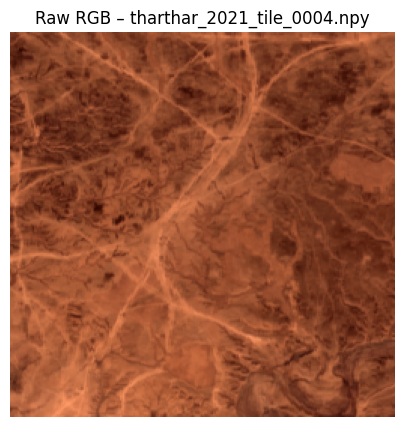

In [12]:
import matplotlib.pyplot as plt

img_tile_path = best_path
img_tile = np.load(img_tile_path).astype('float32')   # (256,256,4)

# extract B4,B3,B2
rgb = img_tile[..., [2,1,0]]

# simple robust scaling
rgb_disp = rgb - np.nanmin(rgb)
rgb_disp = rgb_disp / (np.nanmax(rgb_disp) + 1e-6)

plt.figure(figsize=(5,5))
plt.imshow(rgb_disp)
plt.title(f"Raw RGB – {os.path.basename(img_tile_path)}")
plt.axis('off')
plt.show()


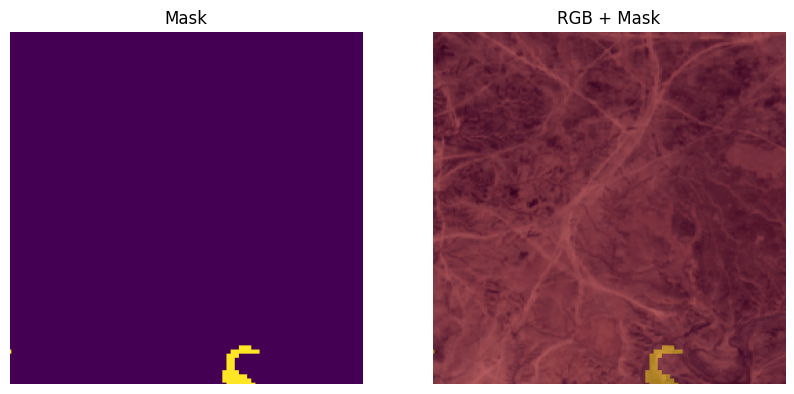

In [13]:
# mask path
msk_tile_path = img_tile_path.replace('/images/', '/masks/')
msk_tile = np.load(msk_tile_path).astype('float32')

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(msk_tile)
plt.title("Mask")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(rgb_disp)
plt.imshow(msk_tile, alpha=0.4)
plt.title("RGB + Mask")
plt.axis('off')
plt.show()


# Functions

In [14]:
'''
  Returns an image plot of mask prediction
'''

def reconstruct_image(model, image, rounded=False):

  # Find model prediction
  reconstruction = model.predict(image).reshape(image.shape[1], image.shape[2])
  # Standardise between 0-1
  reconstruction = reconstruction/np.max(reconstruction)

  # Round to 0-1, binary pixel-by-pixel classification
  if rounded:
    reconstruction = np.round(reconstruction)

  # Plot reconstructed mask (prediction)
  plt.imshow(reconstruction)

In [15]:
'''
  Returns array of mask prediction, given model and image
'''
def reconstruct_array(model, image, rounded=False):

  # Find model prediction
  reconstruction = model.predict(image).reshape(image.shape[1], image.shape[2])

  if rounded:
    reconstruction = np.round(reconstruction)

  return reconstruction # Returns array

In [16]:
'''
  Metric functions for evaluation
'''

def score_eval(model, image, mask): # Gives score of mask vs prediction
  if type(image) != list:
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return accuracy_score(mask.flatten(), reconstruction)

  else: # If a list of images input, find accuracy for each
    scores = []
    for i in range(len(image)):
      reconstruction = model.predict(image[i].reshape(1, 512, 512, 3))
      reconstruction = np.round(reconstruction).flatten()

      scores.append(accuracy_score(mask[i].flatten(), reconstruction))

    return scores

def score_eval2(model, image, mask): # Gives score of mask vs prediction
  if type(image) != list:
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return accuracy_score(mask.flatten(), reconstruction)

  else: # If a list of images input, find accuracy for each
    scores = []
    for i in range(len(image)):
      reconstruction = model.predict(image[i].reshape(1, 512, 512, 4))
      reconstruction = np.round(reconstruction).flatten()

      scores.append(accuracy_score(mask[i].flatten(), reconstruction))

    return scores

def recall_eval(model, image, mask): # Find recall score
  if type(image) != list:
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return recall_score(mask.flatten(), reconstruction, average='weighted')

  else: # If a list of images input, find accuracy for each
    recall = []
    for i in range(len(image)):
        reconstruction = model.predict(image[i]).reshape(mask[i].shape[1], mask[i].shape[2])
        reconstruction = np.round(reconstruction).flatten()

        recall.append(recall_score(mask[i].flatten(), reconstruction, average='weighted'))

    return recall

def precision_eval(model, image, mask): # Find precision score
  if type(image) != list:
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return precision_score(mask.flatten(), reconstruction, average='weighted')

  else: # If a list of images input, find accuracy for each
    precision = []
    for i in range(len(image)):
        reconstruction = model.predict(image[i]).reshape(mask[i].shape[1], mask[i].shape[2])
        reconstruction = np.round(reconstruction).flatten()

        precision.append(precision_score(mask[i].flatten(), reconstruction, average='weighted'))

    return precision

def f1_score_eval(model, image, mask): # Find F1-score
    prec = np.mean(precision_eval(model, image, mask))
    rec = np.mean(recall_eval(model, image, mask))

    if prec + rec == 0:
        return 0

    return 2 * (prec * rec) / (prec + rec)

def f1_score_eval_basic(precision, recall):
    prec = np.mean(precision)
    rec = np.mean(recall)

    if prec + rec == 0:
        return 0

    return 2 * (prec * rec) / (prec + rec)

def produce_mask(image): # Outputs rounded image (binary)
  return np.round(image)

# Ingest and Process 4-band Datasets

## 4-band Amazon dataset

In [17]:
import os

base_dir2 = "/content/tiles_dataset/"

folders = [
    "Training/image",
    "Training/label",
    "Validation/images",
    "Validation/masks",
    "Test/image",
    "Test/mask",
]

for f in folders:
    os.makedirs(os.path.join(base_dir2, f), exist_ok=True)

print("Created dataset folders at:", base_dir2)



Created dataset folders at: /content/tiles_dataset/


In [18]:
import glob, shutil
from sklearn.model_selection import train_test_split

TILES_IMG = "/content/tiles/images/"
TILES_MSK = "/content/tiles/masks/"

img_paths = sorted(glob.glob(os.path.join(TILES_IMG, "*.npy")))
msk_paths = [p.replace("/images/", "/masks/") for p in img_paths]

print("Total tiles found:", len(img_paths))

# 70% train, 15% validation, 15% test
X_train, X_tmp, y_train, y_tmp = train_test_split(
    img_paths, msk_paths, test_size=0.30, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.50, random_state=42
)

def copy_pairs(img_list, msk_list, img_dest, msk_dest):
    for img, msk in zip(img_list, msk_list):
        shutil.copy(img, img_dest)
        shutil.copy(msk, msk_dest)

copy_pairs(X_train, y_train, base_dir2 + "Training/image/", base_dir2 + "Training/label/")
copy_pairs(X_val,   y_val,   base_dir2 + "Validation/images/", base_dir2 + "Validation/masks/")
copy_pairs(X_test,  y_test,  base_dir2 + "Test/image/",       base_dir2 + "Test/mask/")

print("Tiles copied into Train / Val / Test successfully.")


Total tiles found: 1540
Tiles copied into Train / Val / Test successfully.


In [19]:
import numpy as np

train_img_dir = base_dir2 + "Training/image/"
train_msk_dir = base_dir2 + "Training/label/"

training_images2 = []
training_masks2 = []

training_files = sorted(os.listdir(train_img_dir))

for n in training_files:
    img = np.load(train_img_dir + n).astype('float32')       # (256,256,4)
    msk = np.load(train_msk_dir + n).astype('float32')       # (256,256)

    # normalise image per tile
    img = img - np.nanmin(img)
    img = img / (np.nanmax(img) + 1e-6)

    # binarise + add channel dim
    msk = (msk > 0.5).astype('float32')[..., np.newaxis]     # (256,256,1)

    training_images2.append(img)
    training_masks2.append(msk)

training_images2 = np.stack(training_images2)
training_masks2  = np.stack(training_masks2)

print("Train X:", training_images2.shape)
print("Train y:", training_masks2.shape)


Train X: (1078, 256, 256, 4)
Train y: (1078, 256, 256, 1)


In [20]:
val_img_dir = base_dir2 + "Validation/images/"
val_msk_dir = base_dir2 + "Validation/masks/"

validation_images2 = []
validation_masks2 = []

validation_files = sorted(os.listdir(val_img_dir))

for n in validation_files:
    img = np.load(val_img_dir + n).astype('float32')
    msk = np.load(val_msk_dir + n).astype('float32')

    img = img - np.nanmin(img)
    img = img / (np.nanmax(img) + 1e-6)

    msk = (msk > 0.5).astype('float32')[..., np.newaxis]

    validation_images2.append(img)
    validation_masks2.append(msk)

validation_images2 = np.stack(validation_images2)
validation_masks2  = np.stack(validation_masks2)

print("Val X:", validation_images2.shape)
print("Val y:", validation_masks2.shape)


Val X: (231, 256, 256, 4)
Val y: (231, 256, 256, 1)


In [21]:
test_img_dir = base_dir2 + "Test/image/"
test_msk_dir = base_dir2 + "Test/mask/"

test_images2 = []
test_masks2 = []

test_files = sorted(os.listdir(test_img_dir))

for n in test_files:
    img = np.load(test_img_dir + n).astype('float32')
    msk = np.load(test_msk_dir + n).astype('float32')

    img = img - np.nanmin(img)
    img = img / (np.nanmax(img) + 1e-6)

    msk = (msk > 0.5).astype('float32')[..., np.newaxis]

    test_images2.append(img)
    test_masks2.append(msk)

test_images2 = np.stack(test_images2)
test_masks2  = np.stack(test_masks2)

print("Test X:", test_images2.shape)
print("Test y:", test_masks2.shape)


Test X: (231, 256, 256, 4)
Test y: (231, 256, 256, 1)


Train X: (1078, 256, 256, 4)
Train y: (1078, 256, 256, 1)


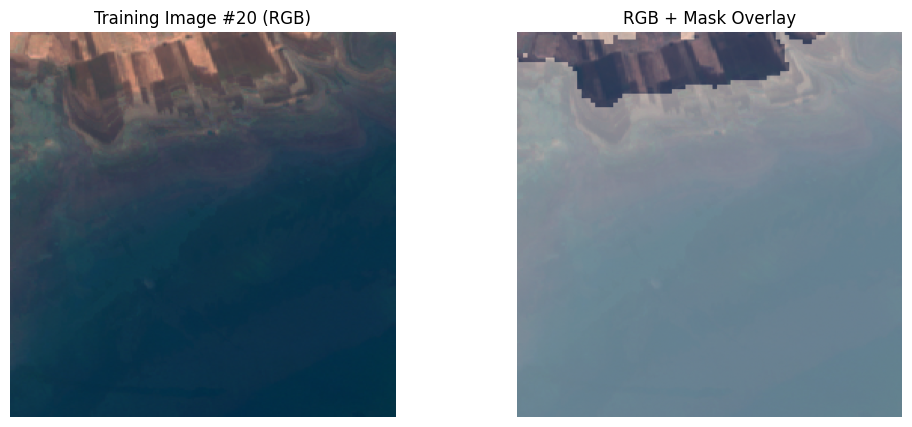

In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Base directory containing Training/, Validation/, Test/
base_dir2 = "/content/tiles_dataset/"

# -----------------------------
# 1. LOAD TRAINING IMAGES + MASKS
# -----------------------------

train_img_dir = os.path.join(base_dir2, "Training/image")
train_msk_dir = os.path.join(base_dir2, "Training/label")

training_images2 = []
training_masks2 = []

training_files = sorted(os.listdir(train_img_dir))

for n in training_files:
    # Load .npy tiles
    img = np.load(os.path.join(train_img_dir, n)).astype('float32')   # (256,256,4)
    msk = np.load(os.path.join(train_msk_dir, n)).astype('float32')   # (256,256)

    # Normalise per tile (Safer than dividing by 3000 or 10000)
    img = img - np.nanmin(img)
    img = img / (np.nanmax(img) + 1e-6)

    # Convert mask → binary {0,1} and add channel dim
    msk = (msk > 0.5).astype('float32')[..., np.newaxis]              # (256,256,1)

    training_images2.append(img)
    training_masks2.append(msk)

training_images2 = np.stack(training_images2)  # shape: (N,256,256,4)
training_masks2  = np.stack(training_masks2)   # shape: (N,256,256,1)

print("Train X:", training_images2.shape)
print("Train y:", training_masks2.shape)


# -----------------------------
# 2. FUNCTION TO SHOW A TRAIN IMAGE AS RGB (B4,B3,B2)
# -----------------------------

def show_train_example(idx):
    img  = training_images2[idx]        # (256,256,4)
    mask = training_masks2[idx][...,0]  # (256,256)

    # Build RGB (Sentinel-2 True Colour)
    # B4 = Red (index 2)
    # B3 = Green (index 1)
    # B2 = Blue (index 0)
    rgb = img[..., [2,1,0]]

    # Normalise for display
    rgb_disp = (rgb - rgb.min()) / (rgb.max() + 1e-6)

    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.imshow(rgb_disp)
    plt.title(f"Training Image #{idx} (RGB)")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(rgb_disp)
    plt.imshow(mask, alpha=0.4, cmap="Blues")
    plt.title("RGB + Mask Overlay")
    plt.axis("off")

    plt.show()


# -----------------------------
# 3. SHOW EXAMPLE IMAGE
# -----------------------------

show_train_example(20)   # change index freely


In [23]:
# Pre-process data, reshaping and transposing
for i in range(len(training_images2)):
  training_images2[i] = training_images2[i].astype('float32')
  training_images2[i] = training_images2[i].T

for i in range(len(training_masks2)):
  training_masks2[i] = training_masks2[i].reshape(1,512,512,1)
  training_masks2[i] = training_masks2[i].T

for i in range(len(validation_images2)):
  validation_images2[i] = validation_images2[i].astype('float32')
  validation_images2[i] = validation_images2[i].T

for i in range(len(validation_masks2)):
  validation_masks2[i] = validation_masks2[i].reshape(1,512,512,1)
  validation_masks2[i] = validation_masks2[i].T

for i in range(len(test_images2)):
  test_images2[i] = test_images2[i].astype('float32')
  test_images2[i] = test_images2[i].T

for i in range(len(test_masks2)):
  test_masks2[i] = test_masks2[i].reshape(1,512,512,1)
  test_masks2[i] = test_masks2[i].T

for i in range(len(training_images2)):
  training_images2[i] = training_images2[i].reshape(-1,512,512,4)

for i in range(len(validation_images2)):
  validation_images2[i] = validation_images2[i].reshape(-1,512,512,4)

for i in range(len(test_images2)):
  test_images2[i] = test_images2[i].reshape(-1,512,512,4)

ValueError: could not broadcast input array from shape (4,256,256) into shape (256,256,4)

## 4-band Atlantic Forest dataset

In [ ]:
download = True # True if files don't already exist in same directory
base_dir3 = r"./ATLANTIC FOREST/"

In [ ]:
# Download data (Atlantic Forest)
if download:
    url = 'https://zenodo.org/record/4498086/files/ATLANTIC%20FOREST.rar?download=1'
    r = requests.get(url, allow_redirects=True)
    open('data3.rar', 'wb').write(r.content)

    if sys.platform != 'darwin':
        pyunpack.Archive('data3.rar').extractall('')

    else:
        with RarFile('data3.rar') as rf:
            rf.extractall()


In [ ]:
# Ingest images and normalise

## Training images
training_images_list3 = os.listdir(r"{}Training/image/".format(base_dir3))[0:250]
training_masks_list3 = []
training_images3 = []
for n in training_images_list3:
  training_masks_list3.append(n)
  a = (np.array(rxr.open_rasterio(r"{}Training/image/{}".format(base_dir3,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  training_images3.append(a)

## Training masks
training_masks3 = []
for n in training_masks_list3:
  a = (np.array(rxr.open_rasterio(r"{}Training/label/{}".format(base_dir3,n))))
  training_masks3.append(a)

## Test images
test_images_list3 = os.listdir(r"{}Test/image/".format(base_dir3))
test_masks_list3 = []
test_images3 = []
for n in test_images_list3:
  test_masks_list3.append(n)
  a = (np.array(rxr.open_rasterio(r"{}Test/image/{}".format(base_dir3,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  test_images3.append(a)

## Test masks
test_masks3 = []
for n in test_masks_list3:
  a = (np.array(rxr.open_rasterio(r"{}Test/mask/{}".format(base_dir3,n))))
  test_masks3.append(a)

## Validation images
validation_images_list3 = os.listdir(r"{}Validation/images/".format(base_dir3))
validation_masks_list3 = []
validation_images3 = []
for n in validation_images_list3:
  validation_masks_list3.append(n)
  a = (np.array(rxr.open_rasterio(r"{}Validation/images/{}".format(base_dir3,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  validation_images3.append(a)

## Validation masks
validation_masks3 = []
for n in validation_masks_list3:
  a = (np.array(rxr.open_rasterio(r"{}Validation/masks/{}".format(base_dir3,n))))
  validation_masks3.append(a)

In [ ]:
# Pre-process data, reshaping and transposing
for i in range(len(training_images3)):
  training_images3[i] = training_images3[i].astype('float32')
  training_images3[i] = training_images3[i].T

for i in range(len(training_masks3)):
  training_masks3[i] = training_masks3[i].reshape(1,512,512,1)
  training_masks3[i] = training_masks3[i].T

for i in range(len(validation_images3)):
  validation_images3[i] = validation_images3[i].astype('float32')
  validation_images3[i] = validation_images3[i].T

for i in range(len(validation_masks3)):
  validation_masks3[i] = validation_masks3[i].reshape(1,512,512,1)
  validation_masks3[i] = validation_masks3[i].T

for i in range(len(test_images3)):
  test_images3[i] = test_images3[i].astype('float32')
  test_images3[i] = test_images3[i].T

for i in range(len(test_masks3)):
  test_masks3[i] = test_masks3[i].reshape(1,512,512,1)
  test_masks3[i] = test_masks3[i].T


for i in range(len(training_images3)):
  training_images3[i] = training_images3[i].reshape(-1,512,512,4)

for i in range(len(validation_images3)):
  validation_images3[i] = validation_images3[i].reshape(-1,512,512,4)

for i in range(len(test_images3)):
  test_images3[i] = test_images3[i].reshape(-1,512,512,4)

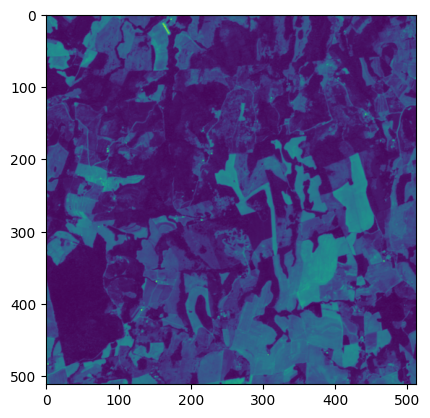

In [ ]:
# Plot example training image first band
plt.imshow(training_images3[0].reshape(512,512,4)[:,:,0])

In [ ]:
# Create TensorFlow datasets for training and validation sets
train_df_4band_atlantic = tf.data.Dataset.from_tensor_slices((training_images3[0:250], training_masks3[0:250]))
validation_df_4band_atlantic = tf.data.Dataset.from_tensor_slices((validation_images3, validation_masks3))

# Models

## U-Net

In [24]:
'''
  Convolutional block with set parameters and activation layer after
'''

def convBlock(input, filters, kernel, kernel_init='he_normal', act='relu', transpose=False):
  if transpose == False:
    #conv = ZeroPadding2D((1,1))(input)
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
  else:
    #conv = ZeroPadding2D((1,1))(input)
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)

  conv = Activation(act)(conv)
  return conv

'''
  U-Net model
'''

def UNet(trained_weights = None, input_size = (512,512,3), drop_rate = 0.25, lr=0.0001):

    ## Can add pretrained weights by specifying 'trained_weights'

    # Input layer
    inputs = Input(input_size)

    ## Contraction phase
    conv1 = convBlock(inputs, 64, 3)
    conv1 = convBlock(conv1, 64, 3)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = convBlock(pool1, 128, 3)
    conv2 = convBlock(conv2, 128, 3)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    #drop2 = Dropout(drop_rate)(pool2)

    conv3 = convBlock(pool2, 256, 3)
    conv3 = convBlock(conv3, 256, 3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    #drop3 = Dropout(drop_rate)(pool3)

    conv4 = convBlock(pool3, 512, 3)
    conv4 = convBlock(conv4, 512, 3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    #drop4 = Dropout(drop_rate)(pool4)

    conv5 = convBlock(pool4, 1024, 3)
    conv5 = convBlock(conv5, 1024, 3)

    ## Expansion phase
    up6 = (Conv2DTranspose(512, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv5))
    merge6 = concatenate([conv4,up6])
    conv6 = convBlock(merge6, 512, 3)
    conv6 = convBlock(conv6, 512, 3)
    #conv6 = Dropout(drop_rate)(conv6)

    up7 = (Conv2DTranspose(256, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv6))
    merge7 = concatenate([conv3,up7])
    conv7 = convBlock(merge7, 256, 3)
    conv7 = convBlock(conv7, 256, 3)
    #conv7 = Dropout(drop_rate)(conv7)

    up8 = (Conv2DTranspose(128, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv7))
    merge8 = concatenate([conv2,up8])
    conv8 = convBlock(merge8, 128, 3)
    conv8 = convBlock(conv8, 128, 3)
    #conv8 = Dropout(drop_rate)(conv8)

    up9 = (Conv2DTranspose(64, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv8))
    merge9 = concatenate([conv1,up9])
    conv9 = convBlock(merge9, 64, 3)
    conv9 = convBlock(conv9, 64, 3)

    # Output layer
    conv10 = convBlock(conv9, 1, 1, act='sigmoid')

    model = Model(inputs, conv10)

    model.compile(optimizer = Adam(learning_rate = lr), loss = 'binary_crossentropy', metrics = ['accuracy', 'mse'])

    if trained_weights != None:
    	model.load_weights(trained_weights)

    return model

In [25]:
# Print model layers and number of parameters
UNet().summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 512, 512,  │          0 │ conv2d[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 512, 512,  │          0 │ conv2d_1[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 256, 256,  │          0 │ conv2d_2[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 256, 256,  │          0 │ conv2d_3[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 128, 128,  │          0 │ conv2d_4[0][0]    │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │    590,080 │ activation_4[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 128, 128,  │          0 │ conv2d_5[0][0]    │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ activation_5[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │  1,180,160 │ max_pooling2d_2[

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

## Attention U-Net

In [26]:
'''
  Convolutional block with two conv layers and two activation layers
'''

def convBlock2(input, filters, kernel, kernel_init='he_normal', act='relu', transpose=False):
  if transpose == False:
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
    conv = Activation(act)(conv)
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(conv)
    conv = Activation(act)(conv)
  else:
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
    conv = Activation(act)(conv)
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(conv)
    conv = Activation(act)(conv)

  return conv

'''
  Attention block/mechanism
'''
def attention_block(x, gating, inter_shape, drop_rate=0.25):

    # Find shape of inputs
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

    ## Process x vector and gating signal
    # x vector input and processing
    theta_x = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(x)
    theta_x = MaxPooling2D((2,2))(theta_x)
    shape_theta_x = K.int_shape(theta_x)

    # gating signal ""
    phi_g = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(gating)
    shape_phi_g = K.int_shape(phi_g)

    # Add components
    concat_xg = add([phi_g, theta_x])
    act_xg = Activation('relu')(concat_xg)

    # Apply convolution
    psi = Conv2D(1, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(act_xg)

    # Apply sigmoid activation
    sigmoid_xg = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)

    # UpSample and resample to correct size
    upsample_psi = UpSampling2D(
        interpolation='bilinear',
        size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2])
    )(sigmoid_xg)

    # No tf.broadcast_to – Keras will broadcast automatically in multiply()
    y = multiply([upsample_psi, x])


    return y


'''
  Attention U-Net model
'''

def UNetAM(trained_weights = None, input_size = (512,512,3), drop_rate = 0.25, lr=0.0001, filter_base=16):

    ## Can add pretrained weights by specifying 'trained_weights'

    # Input layer
    inputs = Input(input_size, batch_size=1)

    ## Contraction phase
    conv = convBlock2(inputs, filter_base, 3)
    #conv0 = Dropout(drop_rate)(conv0)

    conv0 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv0 = convBlock2(conv0, 2 * filter_base, 3)

    pool0 = MaxPooling2D(pool_size=(2, 2))(conv0)
    conv1 = convBlock2(pool0, 4 * filter_base, 3)
    #conv1 = Dropout(drop_rate)(conv1)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = convBlock2(pool1, 8 * filter_base, 3)
    #conv2 = Dropout(drop_rate)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = convBlock2(pool2, 16 * filter_base, 3)
    #conv3 = Dropout(drop_rate)(conv3)

    ## Expansion phase
    up4 = (Conv2DTranspose(8 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv3))
    merge4 = attention_block(conv2, conv3, 8 * filter_base, drop_rate) # Attention gate
    conv4 = concatenate([up4, merge4])
    conv4 = convBlock2(conv4, 8 * filter_base, 3)

    up5 = (Conv2DTranspose(4 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv4))
    merge5 = attention_block(conv1, conv4, 4 * filter_base, drop_rate) # Attention gate
    conv5 = concatenate([up5, merge5])
    conv5 = convBlock2(conv5, 4 * filter_base, 3)

    up6 = (Conv2DTranspose(2 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv5))
    merge6 = attention_block(conv0, conv5, 2 * filter_base, drop_rate) # Attention gate
    conv6 = concatenate([up6, merge6])
    conv6 = convBlock2(conv6, 2 * filter_base, 3)

    up7 = (Conv2DTranspose(1 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv6))
    merge7 = attention_block(conv, conv6, 1 * filter_base, drop_rate) # Attention gate
    conv7 = concatenate([up7, merge7])
    conv7 = concatenate([up7, conv])
    conv7 = convBlock2(conv7, 1 * filter_base, 3)

    ## Output layer
    out = convBlock(conv7, 1, 1, act='sigmoid')

    model = Model(inputs, out)

    model.compile(optimizer = Adam(learning_rate = lr), loss = binary_crossentropy, metrics = ['accuracy', 'mse'])

    if trained_weights != None:
    	model.load_weights(trained_weights)

    return model

In [28]:
# Print model layers and number of parameters
UNetAM().summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (1, 512, 512, 3)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_50 (Conv2D)  │ (1, 512, 512, 16) │        448 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_46       │ (1, 512, 512, 16) │          0 │ conv2d_50[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_51 (Conv2D)  │ (1, 512, 512, 16) │      2,320 │ activation_46[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_47       │ (1, 512, 512, 16) │          0 │ conv2d_51[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (1, 256, 256, 16) │          0 │ activation_47[0]… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_52 (Conv2D)  │ (1, 256, 256, 32) │      4,640 │ max_pooling2d_12… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_48       │ (1, 256, 256, 32) │          0 │ conv2d_52[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_53 (Conv2D)  │ (1, 256, 256, 32) │      9,248 │ activation_48[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_49       │ (1, 256, 256, 32) │          0 │ conv2d_53[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (1, 128, 128, 32) │          0 │ activation_49[0]… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_54 (Conv2D)  │ (1, 128, 128, 64) │     18,496 │ max_pooling2d_13… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_50       │ (1, 128, 128, 64) │          0 │ conv2d_54[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_55 (Conv2D)  │ (1, 128, 128, 64) │     36,928 │ activation_50[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_51       │ (1, 128, 128, 64) │          0 │ conv2d_55[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (1, 64, 64, 64)   │          0 │ activation_51[0]… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_56 (Conv2D)  │ (1, 64, 64, 128)  │     73,856 │ max_pooling2d_14… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_52       │ (1, 64, 64, 128)  │          0 │ conv2d_56[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (1, 64, 64, 128)  │    147,584 │ activation_52[0]… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,006,292 (7.65 MB)

 Trainable params: 2,006,292 (7.65 MB)

 Non-trainable params: 0 (0.00 B)

# Train on 4-band data

## Train on 4-band Amazon data

### U-Net

In [29]:
from keras.callbacks import ModelCheckpoint

# Build 4-band UNet for 256×256 tiles
model_unet_4band = UNet(input_size=(256,256,4), lr=0.0001)

import tensorflow as tf

BATCH_SIZE = 8

train_ds = tf.data.Dataset.from_tensor_slices((training_images2, training_masks2))
train_ds = train_ds.shuffle(2000).batch(BATCH_SIZE).repeat()

val_ds = tf.data.Dataset.from_tensor_slices((validation_images2, validation_masks2))
val_ds = val_ds.batch(BATCH_SIZE)


# Save best model by validation accuracy
save_model_4band = ModelCheckpoint(
    'unet-4band-lakes.keras',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True
)
# Train directly on NumPy arrays
history_4band = model_unet_4band.fit(
    train_ds,
    steps_per_epoch=100,          # same style as original code
    epochs=30,                    # you can increase to 40–60
    validation_data=val_ds,
    callbacks=[save_model_4band],
    verbose=1
)


Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.6366 - loss: 0.6222 - mse: 0.2211
Epoch 1: val_accuracy improved from -inf to 0.75321, saving model to unet-4band-lakes.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 79s 416ms/step - accuracy: 0.6370 - loss: 0.6216 - mse: 0.2209 - val_accuracy: 0.7532 - val_loss: 0.5036 - val_mse: 0.1730
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.7219 - loss: 0.5104 - mse: 0.1777
Epoch 2: val_accuracy did not improve from 0.75321
100/100 ━━━━━━━━━━━━━━━━━━━━ 47s 468ms/step - accuracy: 0.7220 - loss: 0.5103 - mse: 0.1776 - val_accuracy: 0.7354 - val_loss: 0.4855 - val_mse: 0.1677
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.7305 - loss: 0.5147 - mse: 0.1788
Epoch 3: val_accuracy did not improve from 0.75321
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 217ms/step - accuracy: 0.7306 - loss: 0.5144 - mse: 0.1787 - val_accuracy: 0.7338 - val_loss: 0.4956 - val_mse: 0.1690
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2

In [30]:
# Save model history
np.save('unet-4d-history.npy',model_unet_4band.history.history)

In [31]:
# Copy models to drive
!cp unet-4band-lakes.keras /content/drive/MyDrive/Diss/
!cp unet-4d-history.npy drive/MyDrive/Diss/

### Attention U-Net

In [37]:

BATCH_SIZE = 8

train_ds = tf.data.Dataset.from_tensor_slices((training_images2, training_masks2))
train_ds = train_ds.shuffle(2000).batch(BATCH_SIZE).repeat()

val_ds = tf.data.Dataset.from_tensor_slices((validation_images2, validation_masks2))
val_ds = val_ds.batch(BATCH_SIZE)

# ---------------------------
# 2) Build Attention U-Net (4-band, 256x256)
#    UNetAM must already be defined in your notebook
# ---------------------------
model_attention_unet_4band = UNetAM(
    input_size=(256, 256, 4),
    filter_base=16,
    lr=0.0005
)

# ---------------------------
# 3) Checkpoint callback (attention model)
# ---------------------------
save_model_4band_attention = ModelCheckpoint(
    'unet-attention-4band-lakes.keras',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True
)

# ---------------------------
# 4) Train with generator (same style as original Amazon code)
# ---------------------------
history_attention_4band = model_attention_unet_4band.fit(
    train_ds,
    steps_per_epoch=100,       # like your original: more iterations per epoch
    epochs=60,                 # same as your old attention UNet
    validation_data=val_ds,
    callbacks=[save_model_4band_attention],
    verbose=1
)


Epoch 1/60
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5358 - loss: 0.6865 - mse: 0.2482
Epoch 1: val_accuracy improved from -inf to 0.71505, saving model to unet-attention-4band-lakes.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 32s 103ms/step - accuracy: 0.5378 - loss: 0.6849 - mse: 0.2475 - val_accuracy: 0.7150 - val_loss: 0.5284 - val_mse: 0.1867
Epoch 2/60
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.6897 - loss: 0.5237 - mse: 0.1842
Epoch 2: val_accuracy improved from 0.71505 to 0.72230, saving model to unet-attention-4band-lakes.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 169ms/step - accuracy: 0.6899 - loss: 0.5236 - mse: 0.1842 - val_accuracy: 0.7223 - val_loss: 0.5062 - val_mse: 0.1772
Epoch 3/60
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7304 - loss: 0.4907 - mse: 0.1705
Epoch 3: val_accuracy improved from 0.72230 to 0.74223, saving model to unet-attention-4band-lakes.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.7303 - loss: 0.4908 - ms

In [40]:
# Save model history
np.save('unet-attention-4d-history.npy',model_attention_unet_4band.history.history)

In [39]:
# Copy models to drive
!cp unet-attention-4band-lakes.keras /content/drive/MyDrive/Diss/
!cp unet-attention-4d-history.npy drive/MyDrive/Diss/

## Train on 4-band Atlantic data

### U-Net

In [ ]:
# Train U-Net with generator
model_unet_4band_atlantic = UNet(input_size=(512, 512, 4), lr=0.0001)
save_model_4band_atlantic = ModelCheckpoint('unet-4d-atlantic.keras', monitor='val_accuracy',verbose=1, save_best_only=True)
model_unet_4band_atlantic.fit(train_df_4band_atlantic, epochs = 20, validation_data = validation_df_4band_atlantic, callbacks=[save_model_4band_atlantic])

In [ ]:
# Save model history
np.save('unet-4d-atlantic-history.npy',model_unet_4band_atlantic.history.history)

In [ ]:
# Copy models to drive
!cp unet-4d-atlantic.keras drive/MyDrive/Diss/
!cp unet-4d-atlantic-history.npy drive/MyDrive/Diss/

### Attention U-Net

In [ ]:
# Train Attention U-Net with generator
model_attention_unet_4band_atlantic = UNetAM(input_size=(512,512,4), filter_base=16, lr=0.0005)
save_model_4band_attention_atlantic = ModelCheckpoint('unet-attention-4d-atlantic.keras', monitor='val_accuracy',verbose=1, save_best_only=True)
model_attention_unet_4band_atlantic.fit(train_df_4band_atlantic, epochs = 60, validation_data = validation_df_4band_atlantic, callbacks=[save_model_4band_attention_atlantic])

In [ ]:
# Save model history
np.save('unet-attention-4d-atlantic-history.npy',model_attention_unet_4band_atlantic.history.history)

In [ ]:
# Copy models to drive
!cp unet-attention-4d-atlantic.keras drive/MyDrive/Diss/
!cp unet-attention-4d-atlantic-history.npy drive/MyDrive/Diss/

# Import Models and Compute Metrics

# **Iraq Lake Data**

In [41]:
from keras.models import load_model

# Load 4-band UNet models
unet_4d = load_model('unet-4band-lakes.keras')
attention_unet_4d = load_model('unet-attention-4band-lakes.keras')

# Load histories
unet_4d_history = np.load('unet-4d-history.npy', allow_pickle=True).item()
attention_unet_4d_history = np.load('unet-attention-4d-history.npy', allow_pickle=True).item()

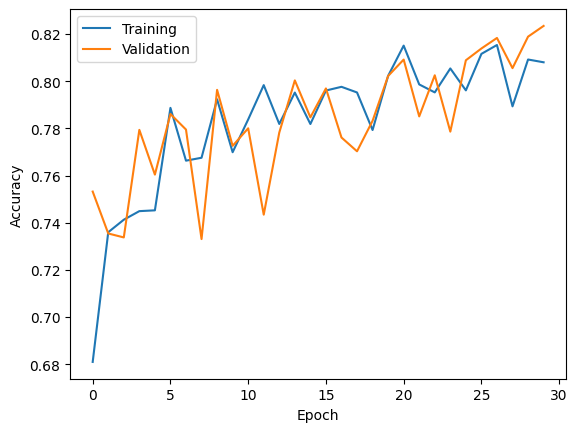

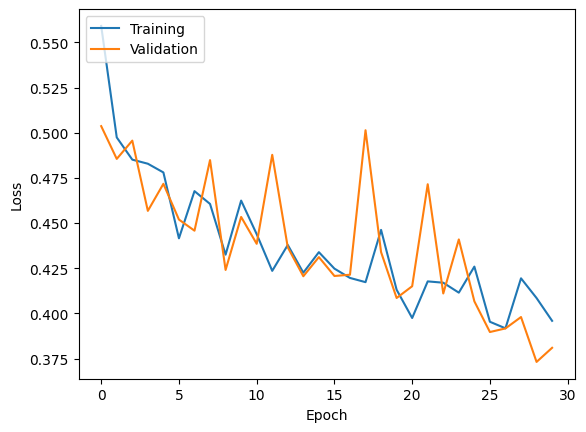

In [42]:
# Plot accuracy and loss for U-Net

## Accuracy
plt.plot(unet_4d_history['accuracy'])
plt.plot(unet_4d_history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

## Loss
plt.plot(unet_4d_history['loss'])
plt.plot(unet_4d_history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

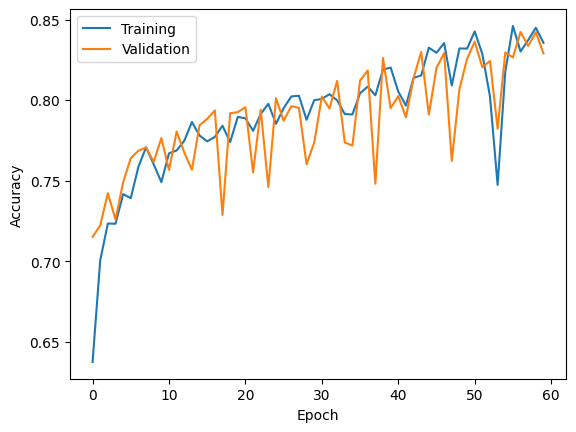

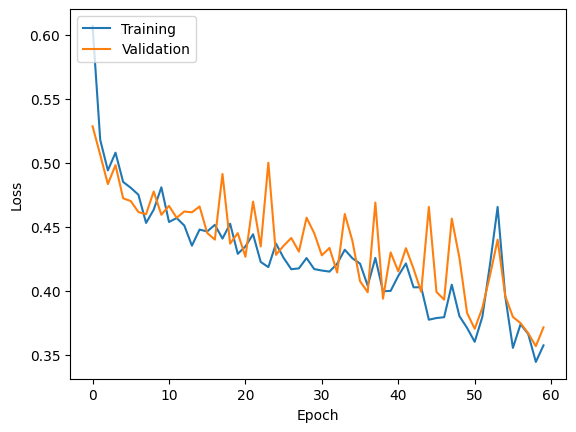

In [43]:
# Plot accuracy and loss for Attention U-Net

## Accuracy
plt.plot(attention_unet_4d_history['accuracy'])
plt.plot(attention_unet_4d_history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

## Loss
plt.plot(attention_unet_4d_history['loss'])
plt.plot(attention_unet_4d_history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

In [45]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np

def score_eval2(model, images, masks):
    """
    Evaluate model on a whole batch of images + masks.
    images: (N, H, W, C)
    masks:  (N, H, W) or (N, H, W, 1)
    """
    # Predict on all images
    preds = model.predict(images)

    # Drop channel dimension if it's (N, H, W, 1)
    if preds.ndim == 4 and preds.shape[-1] == 1:
        preds = preds[..., 0]
    if masks.ndim == 4 and masks.shape[-1] == 1:
        masks = masks[..., 0]

    # Binarise predictions (0/1)
    preds_bin = np.round(preds).astype(np.uint8)

    # Flatten everything to 1D for global scores
    y_pred = preds_bin.flatten()
    y_true = masks.astype(np.uint8).flatten()

    # Sanity check
    assert y_pred.shape == y_true.shape, f"Shape mismatch: {y_pred.shape} vs {y_true.shape}"

    scores = {
        "accuracy":  accuracy_score(y_true, y_pred),
        "f1":        f1_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall":    recall_score(y_true, y_pred),
    }
    return scores


In [46]:
# Scores of each model
unet_4d_score = (score_eval2(unet_4d, validation_images2, validation_masks2))
am_unet_4d_score = (score_eval2(attention_unet_4d, validation_images2, validation_masks2))

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 279ms/step


In [49]:
from sklearn.metrics import precision_score, recall_score
import numpy as np

def precision_eval(model, images, masks):
    """
    Global precision over a batch of images.
    images: (N, H, W, C)
    masks:  (N, H, W) or (N, H, W, 1)
    """
    preds = model.predict(images)

    # Drop channel dim if present
    if preds.ndim == 4 and preds.shape[-1] == 1:
        preds = preds[..., 0]
    if masks.ndim == 4 and masks.shape[-1] == 1:
        masks = masks[..., 0]

    # Binarise predictions
    preds_bin = np.round(preds).astype(np.uint8)

    # Flatten
    y_pred = preds_bin.flatten()
    y_true = masks.astype(np.uint8).flatten()

    assert y_pred.shape == y_true.shape, f"Shape mismatch: {y_pred.shape} vs {y_true.shape}"

    return precision_score(y_true, y_pred)


def recall_eval(model, images, masks):
    """
    Global recall over a batch of images.
    images: (N, H, W, C)
    masks:  (N, H, W) or (N, H, W, 1)
    """
    preds = model.predict(images)

    # Drop channel dim if present
    if preds.ndim == 4 and preds.shape[-1] == 1:
        preds = preds[..., 0]
    if masks.ndim == 4 and masks.shape[-1] == 1:
        masks = masks[..., 0]

    # Binarise predictions
    preds_bin = np.round(preds).astype(np.uint8)

    # Flatten
    y_pred = preds_bin.flatten()
    y_true = masks.astype(np.uint8).flatten()

    assert y_pred.shape == y_true.shape, f"Shape mismatch: {y_pred.shape} vs {y_true.shape}"

    return recall_score(y_true, y_pred)


In [50]:
# Precision and recall of each model
unet_4d_precision = (precision_eval(unet_4d, validation_images2, validation_masks2))
am_unet_4d_precision = (precision_eval(attention_unet_4d, validation_images2, validation_masks2))

unet_4d_recall = (recall_eval(unet_4d, validation_images2, validation_masks2))
am_unet_4d_recall = (recall_eval(attention_unet_4d, validation_images2, validation_masks2))

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


In [51]:
# F1-scores of each model
unet_4d_f1_score = (f1_score_eval_basic(unet_4d_precision, unet_4d_recall))
am_unet_4d_f1_score = (f1_score_eval_basic(am_unet_4d_precision, am_unet_4d_recall))

In [53]:
print("UNet accuracy:", unet_4d_score["accuracy"])
print("UNet f1:", unet_4d_score["f1"])
print("UNet precision:", unet_4d_score["precision"])
print("UNet recall:", unet_4d_score["recall"])

print("\nAttention UNet accuracy:", am_unet_4d_score["accuracy"])
print("Attention UNet f1:", am_unet_4d_score["f1"])
print("Attention UNet precision:", am_unet_4d_score["precision"])
print("Attention UNet recall:", am_unet_4d_score["recall"])


UNet accuracy: 0.8234617555296266
UNet f1: 0.6640514794742541
UNet precision: 0.7235010974243875
UNet recall: 0.6136299063423089

Attention UNet accuracy: 0.8422538460075081
Attention UNet f1: 0.7029265853270172
Attention UNet precision: 0.7566021238734245
Attention UNet recall: 0.6563623459608016


In [56]:
# Print precision eval results for each model
print('U-Net precision: ', np.mean(unet_4d_precision), np.std(unet_4d_precision))
print('Attention U-Net precision: ', np.mean(am_unet_4d_precision), np.std(am_unet_4d_precision))

U-Net precision:  0.7235010974243875 0.0
Attention U-Net precision:  0.7566021238734245 0.0


In [55]:
# Print recall eval results for each model
print('U-Net recall: ', np.mean(unet_4d_recall), np.std(unet_4d_recall))
print('Attention U-Net recall: ', np.mean(am_unet_4d_recall), np.std(am_unet_4d_recall))

U-Net recall:  0.6136299063423089 0.0
Attention U-Net recall:  0.6563623459608016 0.0


In [54]:
# Print f1-score eval results for each model
print('U-Net F1-score: ', np.mean(unet_4d_f1_score))
print('Attention U-Net F1-score: ', np.mean(am_unet_4d_f1_score))

U-Net F1-score:  0.6640514794742541
Attention U-Net F1-score:  0.7029265853270172


### Amazon on unseen Atlantic data

In [ ]:
# Score
unet_amazon_on_atlantic_score = score_eval2(unet_4d, validation_images3+test_images3, validation_masks3+test_masks3)
am_unet_amazon_on_atlantic_score = score_eval2(attention_unet_4d, validation_images3+test_images3, validation_masks3+test_masks3)

# Precision
unet_amazon_on_atlantic_precision = (precision_eval(unet_4d, validation_images3+test_images3, validation_masks3+test_masks3))
am_unet_amazon_on_atlantic_precision = (precision_eval(attention_unet_4d, validation_images3+test_images3, validation_masks3+test_masks3))

# Recall
unet_amazon_on_atlantic_recall = (recall_eval(unet_4d, validation_images3+test_images3, validation_masks3+test_masks3))
am_unet_amazon_on_atlantic_recall = (recall_eval(attention_unet_4d, validation_images3+test_images3, validation_masks3+test_masks3))

# F1-scores of each model
unet_amazon_on_atlantic_f1_score = (f1_score_eval_basic(unet_amazon_on_atlantic_precision, unet_amazon_on_atlantic_recall))
am_unet_amazon_on_atlantic_f1_score = (f1_score_eval_basic(am_unet_amazon_on_atlantic_precision, am_unet_amazon_on_atlantic_recall))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━

In [ ]:
# Print metrics
print('U-Net score: ', np.mean(unet_amazon_on_atlantic_score), np.std(unet_amazon_on_atlantic_score))
print('Attention U-Net score: ', np.mean(am_unet_amazon_on_atlantic_score), np.std(am_unet_amazon_on_atlantic_score))

print('U-Net precision: ', np.mean(unet_amazon_on_atlantic_precision), np.std(unet_amazon_on_atlantic_precision))
print('Attention U-Net precision: ', np.mean(am_unet_amazon_on_atlantic_precision), np.std(am_unet_amazon_on_atlantic_precision))

print('U-Net recall: ', np.mean(unet_amazon_on_atlantic_recall), np.std(unet_amazon_on_atlantic_recall))
print('Attention U-Net recall: ', np.mean(am_unet_amazon_on_atlantic_recall), np.std(am_unet_amazon_on_atlantic_recall))

print('U-Net F1-score: ', unet_amazon_on_atlantic_f1_score)
print('Attention U-Net F1-score: ', am_unet_amazon_on_atlantic_f1_score)

U-Net score:  0.8542702992757162 0.12836392636430188
Attention U-Net score:  0.8591636975606283 0.12318329659878245
U-Net precision:  0.9182457209064412 0.037800420126349536
Attention U-Net precision:  0.9191973657882335 0.03905012219444417
U-Net recall:  0.8542702992757162 0.12836392636430188
Attention U-Net recall:  0.8591636975606283 0.12318329659878245
U-Net F1-score:  0.8851034776281201
Attention U-Net F1-score:  0.8881672275161417


### Atlantic Data

In [ ]:
# Load 4-dim models and history stats
attention_unet_4d_atlantic = load_model('unet-attention-4d-atlantic.keras')
unet_4d_atlantic = load_model('unet-4d-atlantic.keras')

unet_4d_atlantic_history = np.load('unet-4d-atlantic-history.npy', allow_pickle='TRUE').item()
attention_unet_4d_atlantic_history = np.load('unet-attention-4d-atlantic-history.npy', allow_pickle='TRUE').item()

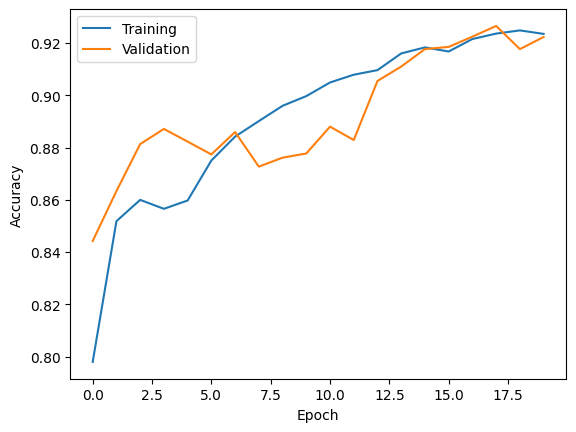

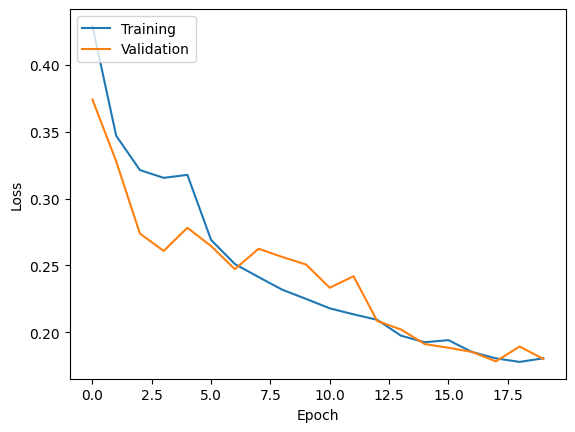

In [ ]:
# Plot accuracy and loss for U-Net

## Accuracy
plt.plot(unet_4d_atlantic_history['accuracy'])
plt.plot(unet_4d_atlantic_history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

## Loss
plt.plot(unet_4d_atlantic_history['loss'])
plt.plot(unet_4d_atlantic_history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

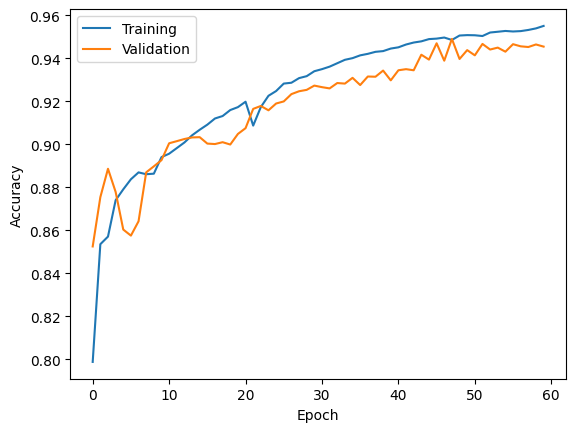

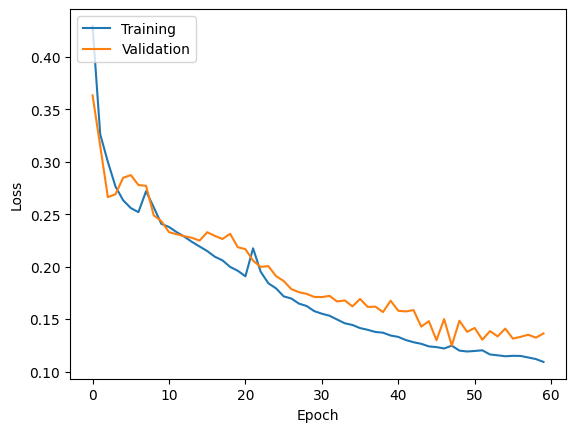

In [ ]:
# Plot accuracy and loss for Attention U-Net

## Accuracy
plt.plot(attention_unet_4d_atlantic_history['accuracy'])
plt.plot(attention_unet_4d_atlantic_history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

## Loss
plt.plot(attention_unet_4d_atlantic_history['loss'])
plt.plot(attention_unet_4d_atlantic_history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

In [ ]:
# Scores of each model
unet_4d_atlantic_score = (score_eval2(unet_4d_atlantic, validation_images3, validation_masks3))
am_unet_4d_atlantic_score = (score_eval2(attention_unet_4d_atlantic, validation_images3, validation_masks3))

# Precision and recall of each model
unet_4d_atlantic_precision = (precision_eval(unet_4d_atlantic, validation_images3, validation_masks3))
am_unet_4d_atlantic_precision = (precision_eval(attention_unet_4d_atlantic, validation_images3, validation_masks3))

unet_4d_atlantic_recall = (recall_eval(unet_4d_atlantic, validation_images3, validation_masks3))
am_unet_4d_atlantic_recall = (recall_eval(attention_unet_4d_atlantic, validation_images3, validation_masks3))

# F1-scores of each model
unet_4d_atlantic_f1_score = (f1_score_eval_basic(unet_4d_atlantic_precision, unet_4d_atlantic_recall))
am_unet_4d_atlantic_f1_score = (f1_score_eval_basic(am_unet_4d_atlantic_precision, am_unet_4d_atlantic_recall))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━

In [ ]:
# Print metrics
print('U-Net score: ', np.mean(unet_4d_atlantic_score), np.std(unet_4d_atlantic_score))
print('Attention U-Net score: ', np.mean(am_unet_4d_atlantic_score), np.std(am_unet_4d_atlantic_score))

print('U-Net precision: ', np.mean(unet_4d_atlantic_precision), np.std(unet_4d_atlantic_precision))
print('Attention U-Net precision: ', np.mean(am_unet_4d_atlantic_precision), np.std(am_unet_4d_atlantic_precision))

print('U-Net recall: ', np.mean(unet_4d_atlantic_recall), np.std(unet_4d_atlantic_recall))
print('Attention U-Net recall: ', np.mean(am_unet_4d_atlantic_recall), np.std(am_unet_4d_atlantic_recall))

print('U-Net F1-score: ', unet_4d_atlantic_f1_score)
print('Attention U-Net F1-score: ', am_unet_4d_atlantic_f1_score)

U-Net score:  0.9265802383422852 0.04601503289151416
Attention U-Net score:  0.9490564346313477 0.03264119099391875
U-Net precision:  0.9345741712156027 0.03659888790046846
Attention U-Net precision:  0.9513473379388816 0.027138617988700715
U-Net recall:  0.9265802383422852 0.04601503289151416
Attention U-Net recall:  0.9490564346313477 0.03264119099391875
U-Net F1-score:  0.9305600372181938
Attention U-Net F1-score:  0.9502005054633018


### Atlantic on unseen Amazon data

In [ ]:
# Score
unet_atlantic_on_amazon_score = score_eval2(unet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2)
am_unet_atlantic_on_amazon_score = score_eval2(attention_unet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2)

# Precision
unet_atlantic_on_amazon_precision = (precision_eval(unet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))
am_unet_atlantic_on_amazon_precision = (precision_eval(attention_unet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))

# Recall
unet_atlantic_on_amazon_recall = (recall_eval(unet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))
am_unet_atlantic_on_amazon_recall = (recall_eval(attention_unet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))

# F1-scores of each model
unet_atlantic_on_amazon_f1_score = (f1_score_eval_basic(unet_atlantic_on_amazon_precision, unet_atlantic_on_amazon_recall))
am_unet_atlantic_on_amazon_f1_score = (f1_score_eval_basic(am_unet_atlantic_on_amazon_precision, am_unet_atlantic_on_amazon_recall))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━

In [ ]:
# Print metrics
print('U-Net score: ', np.mean(unet_atlantic_on_amazon_score), np.std(unet_atlantic_on_amazon_score))
print('Attention U-Net score: ', np.mean(am_unet_atlantic_on_amazon_score), np.std(am_unet_atlantic_on_amazon_score))

print('U-Net precision: ', np.mean(unet_atlantic_on_amazon_precision), np.std(unet_atlantic_on_amazon_precision))
print('Attention U-Net precision: ', np.mean(am_unet_atlantic_on_amazon_precision), np.std(am_unet_atlantic_on_amazon_precision))

print('U-Net recall: ', np.mean(unet_atlantic_on_amazon_recall), np.std(unet_atlantic_on_amazon_recall))
print('Attention U-Net recall: ', np.mean(am_unet_atlantic_on_amazon_recall), np.std(am_unet_atlantic_on_amazon_recall))

print('U-Net F1-score: ', unet_atlantic_on_amazon_f1_score)
print('Attention U-Net F1-score: ', am_unet_atlantic_on_amazon_f1_score)

U-Net score:  0.9039643287658692 0.07955963070699604
Attention U-Net score:  0.9178111394246419 0.0673050814029993
U-Net precision:  0.9322634735532153 0.04569025138179155
Attention U-Net precision:  0.9386418214001312 0.04468769783410032
U-Net recall:  0.9039643287658692 0.07955963070699604
Attention U-Net recall:  0.9178111394246419 0.0673050814029993
U-Net F1-score:  0.9178958340998115
Attention U-Net F1-score:  0.9281096131066372


### Amazon and Atlantic unseen test data

In [ ]:
# Amazon trained model on Amazon test data
# Scores of each model
unet_4d_score_test = (score_eval2(unet_4d, test_images2, test_masks2))
am_unet_4d_score_test = (score_eval2(attention_unet_4d, test_images2, test_masks2))

# Precision and recall of each model
unet_4d_precision_test = (precision_eval(unet_4d, test_images2, test_masks2))
am_unet_4d_precision_test = (precision_eval(attention_unet_4d, test_images2, test_masks2))

unet_4d_recall_test = (recall_eval(unet_4d, test_images2, test_masks2))
am_unet_4d_recall_test = (recall_eval(attention_unet_4d, test_images2, test_masks2))

# F1-scores of each model
unet_4d_f1_score_test = (f1_score_eval_basic(unet_4d_precision_test, unet_4d_recall_test))
am_unet_4d_f1_score_test = (f1_score_eval_basic(am_unet_4d_precision_test, am_unet_4d_recall_test))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


In [ ]:
# Atlantic trained model on Atlantic test data
# Scores of each model
unet_4d_atlantic_score_test = (score_eval2(unet_4d_atlantic, test_images3, test_masks3))
am_unet_4d_atlantic_score_test = (score_eval2(attention_unet_4d_atlantic, test_images3, test_masks3))

# Precision and recall of each model
unet_4d_atlantic_precision_test = (precision_eval(unet_4d_atlantic, test_images3, test_masks3))
am_unet_4d_atlantic_precision_test = (precision_eval(attention_unet_4d_atlantic, test_images3, test_masks3))

unet_4d_atlantic_recall_test = (recall_eval(unet_4d_atlantic, test_images3, test_masks3))
am_unet_4d_atlantic_recall_test = (recall_eval(attention_unet_4d_atlantic, test_images3, test_masks3))

# F1-scores of each model
unet_4d_atlantic_f1_score_test = (f1_score_eval_basic(unet_4d_atlantic_precision_test, unet_4d_atlantic_recall_test))
am_unet_4d_atlantic_f1_score_test = (f1_score_eval_basic(am_unet_4d_atlantic_precision_test, am_unet_4d_atlantic_recall_test))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━

In [ ]:
# Print metrics for Amazon on Amazon Test set
print('U-Net score: ', np.mean(unet_4d_score_test), np.std(unet_4d_score_test))
print('Attention U-Net score: ', np.mean(am_unet_4d_score_test), np.std(am_unet_4d_score_test))

print('U-Net precision: ', np.mean(unet_4d_precision_test), np.std(unet_4d_precision_test))
print('Attention U-Net precision: ', np.mean(am_unet_4d_precision_test), np.std(am_unet_4d_precision_test))

print('U-Net recall: ', np.mean(unet_4d_recall_test), np.std(unet_4d_recall_test))
print('Attention U-Net recall: ', np.mean(am_unet_4d_recall_test), np.std(am_unet_4d_recall_test))

print('U-Net F1-score: ', unet_4d_f1_score_test)
print('Attention U-Net F1-score: ', am_unet_4d_f1_score_test)

U-Net score:  0.9746686935424804 0.017888159851569923
Attention U-Net score:  0.9759273529052734 0.018413787363643908
U-Net precision:  0.9756197217826987 0.016365296589614078
Attention U-Net precision:  0.9768423170641005 0.016816892883506376
U-Net recall:  0.9746686935424804 0.017888159851569923
Attention U-Net recall:  0.9759273529052734 0.018413787363643908
U-Net F1-score:  0.9751439757854203
Attention U-Net F1-score:  0.9763846206328807


In [ ]:
# Print metrics for Atlantic on Atlantic Test set
print('U-Net score: ', np.mean(unet_4d_atlantic_score_test), np.std(unet_4d_atlantic_score_test))
print('Attention U-Net score: ', np.mean(am_unet_4d_atlantic_score_test), np.std(am_unet_4d_atlantic_score_test))

print('U-Net precision: ', np.mean(unet_4d_atlantic_precision_test), np.std(unet_4d_atlantic_precision_test))
print('Attention U-Net precision: ', np.mean(am_unet_4d_atlantic_precision_test), np.std(am_unet_4d_atlantic_precision_test))

print('U-Net recall: ', np.mean(unet_4d_atlantic_recall_test), np.std(unet_4d_atlantic_recall_test))
print('Attention U-Net recall: ', np.mean(am_unet_4d_atlantic_recall_test), np.std(am_unet_4d_atlantic_recall_test))

print('U-Net F1-score: ', unet_4d_atlantic_f1_score_test)
print('Attention U-Net F1-score: ', am_unet_4d_atlantic_f1_score_test)

U-Net score:  0.9220149993896485 0.0680575914467643
Attention U-Net score:  0.945172119140625 0.05267888264042192
U-Net precision:  0.9357995106040077 0.03548028774394467
Attention U-Net precision:  0.9520780402983338 0.02750962780711448
U-Net recall:  0.9220149993896485 0.0680575914467643
Attention U-Net recall:  0.945172119140625 0.05267888264042192
U-Net F1-score:  0.9288561162129515
Attention U-Net F1-score:  0.9486125110693203


# Produce metric datasets for export

## 4-band Amazon data

In [ ]:
scores_4d = [unet_4d_score, am_unet_4d_score]
precision_4d = [unet_4d_precision, am_unet_4d_precision]
recall_4d = [unet_4d_recall, am_unet_4d_recall]
f1_scores_4d = [unet_4d_f1_score, am_unet_4d_f1_score]

metrics_4d = {'classifier': ['U-Net', 'Attention U-Net'],
              'accuracy': [np.mean(n) for n in scores_4d],
              'precision': [np.mean(n) for n in precision_4d],
              'recall': [np.mean(n) for n in recall_4d],
              'f1_score': [np.mean(n) for n in f1_scores_4d],
              'accuracy_std': [np.std(n) for n in scores_4d],
              'precision_std': [np.std(n) for n in precision_4d],
              'recall_std': [np.std(n) for n in recall_4d]
              }
metrics_4d = pd.DataFrame(metrics_4d)
metrics_4d.to_csv('metrics_4d_amazon.csv')
metrics_4d.to_csv('/content/drive/MyDrive/Diss/metrics_4d_amazon.csv')

## 4-band Atlantic Forest data

In [ ]:
scores_4d_atl = [unet_4d_atlantic_score, am_unet_4d_atlantic_score]
precision_4d_atl = [unet_4d_atlantic_precision, am_unet_4d_atlantic_precision]
recall_4d_atl = [unet_4d_atlantic_recall, am_unet_4d_atlantic_recall]
f1_scores_4d_atl = [unet_4d_atlantic_f1_score, am_unet_4d_atlantic_f1_score]

metrics_4d_atl = {'classifier': ['U-Net', 'Attention U-Net'],
              'accuracy': [np.mean(n) for n in scores_4d_atl],
              'precision': [np.mean(n) for n in precision_4d_atl],
              'recall': [np.mean(n) for n in recall_4d_atl],
              'f1_score': [np.mean(n) for n in f1_scores_4d_atl],
              'accuracy_std': [np.std(n) for n in scores_4d_atl],
              'precision_std': [np.std(n) for n in precision_4d_atl],
              'recall_std': [np.std(n) for n in recall_4d_atl]
              }
metrics_4d_atl = pd.DataFrame(metrics_4d_atl)
metrics_4d_atl.to_csv('metrics_4d_atlantic_forest.csv')
metrics_4d_atl.to_csv('/content/drive/MyDrive/Diss/metrics_4d_atlantic_forest.csv')

## Test set data

In [ ]:
scores_4d_test = [unet_4d_score_test, am_unet_4d_score_test]
precision_4d_test = [unet_4d_precision_test, am_unet_4d_precision_test]
recall_4d_test = [unet_4d_recall_test, am_unet_4d_recall_test]
f1_scores_4d_test = [unet_4d_f1_score_test, am_unet_4d_f1_score_test]

metrics_4d_test = {'classifier': ['U-Net', 'Attention U-Net'],
              'accuracy': [np.mean(n) for n in scores_4d_test],
              'precision': [np.mean(n) for n in precision_4d_test],
              'recall': [np.mean(n) for n in recall_4d_test],
              'f1_score': [np.mean(n) for n in f1_scores_4d_test],
              'accuracy_std': [np.std(n) for n in scores_4d_test],
              'precision_std': [np.std(n) for n in precision_4d_test],
              'recall_std': [np.std(n) for n in recall_4d_test]
              }
metrics_4d_test = pd.DataFrame(metrics_4d_test)
metrics_4d_test.to_csv('metrics_4d_amazon_test.csv')
metrics_4d_test.to_csv('/content/drive/MyDrive/Diss/metrics_4d_amazon_test.csv')

In [ ]:
scores_4d_atl_test = [unet_4d_atlantic_score_test, am_unet_4d_atlantic_score_test]
precision_4d_atl_test = [unet_4d_atlantic_precision_test, am_unet_4d_atlantic_precision_test]
recall_4d_atl_test = [unet_4d_atlantic_recall_test, am_unet_4d_atlantic_recall_test]
f1_scores_4d_atl_test = [unet_4d_atlantic_f1_score_test, am_unet_4d_atlantic_f1_score_test]

metrics_4d_atl_test = {'classifier': ['U-Net', 'Attention U-Net'],
              'accuracy': [np.mean(n) for n in scores_4d_atl_test],
              'precision': [np.mean(n) for n in precision_4d_atl_test],
              'recall': [np.mean(n) for n in recall_4d_atl_test],
              'f1_score': [np.mean(n) for n in f1_scores_4d_atl_test],
              'accuracy_std': [np.std(n) for n in scores_4d_atl_test],
              'precision_std': [np.std(n) for n in precision_4d_atl_test],
              'recall_std': [np.std(n) for n in recall_4d_atl_test]
              }
metrics_4d_atl_test = pd.DataFrame(metrics_4d_atl_test)
metrics_4d_atl_test.to_csv('metrics_4d_atlantic_forest_test.csv')
metrics_4d_atl_test.to_csv('/content/drive/MyDrive/Diss/metrics_4d_atlantic_forest_test.csv')

## Testing on opposite dataset (e.g. train on Amazon, test on Atlantic)

In [ ]:
scores_amazon_on_atlantic = [unet_amazon_on_atlantic_score, am_unet_amazon_on_atlantic_score]
precision_amazon_on_atlantic = [unet_amazon_on_atlantic_precision, am_unet_amazon_on_atlantic_precision]
recall_amazon_on_atlantic = [unet_amazon_on_atlantic_recall, am_unet_amazon_on_atlantic_recall]
f1_scores_amazon_on_atlantic = [unet_amazon_on_atlantic_f1_score, am_unet_amazon_on_atlantic_f1_score]

metrics_4d_amazon_on_atlantic = {'classifier': ['U-Net', 'Attention U-Net'],
              'accuracy': [np.mean(n) for n in scores_amazon_on_atlantic],
              'precision': [np.mean(n) for n in precision_amazon_on_atlantic],
              'recall': [np.mean(n) for n in recall_amazon_on_atlantic],
              'f1_score': [np.mean(n) for n in f1_scores_amazon_on_atlantic],
              'accuracy_std': [np.std(n) for n in scores_amazon_on_atlantic],
              'precision_std': [np.std(n) for n in precision_amazon_on_atlantic],
              'recall_std': [np.std(n) for n in recall_amazon_on_atlantic]
              }
metrics_4d_amazon_on_atlantic = pd.DataFrame(metrics_4d_amazon_on_atlantic)
metrics_4d_amazon_on_atlantic.to_csv('metrics_4d_amazon_on_atlantic.csv')
metrics_4d_amazon_on_atlantic.to_csv('/content/drive/MyDrive/Diss/metrics_4d_amazon_on_atlantic.csv')

In [ ]:
scores_atlantic_on_amazon = [unet_atlantic_on_amazon_score, am_unet_atlantic_on_amazon_score]
precision_atlantic_on_amazon = [unet_atlantic_on_amazon_precision, am_unet_atlantic_on_amazon_precision]
recall_atlantic_on_amazon = [unet_atlantic_on_amazon_recall, am_unet_atlantic_on_amazon_recall]
f1_scores_atlantic_on_amazon = [unet_atlantic_on_amazon_f1_score, am_unet_atlantic_on_amazon_f1_score]

metrics_4d_atlantic_on_amazon = {'classifier': ['U-Net', 'Attention U-Net'],
              'accuracy': [np.mean(n) for n in scores_atlantic_on_amazon],
              'precision': [np.mean(n) for n in precision_atlantic_on_amazon],
              'recall': [np.mean(n) for n in recall_atlantic_on_amazon],
              'f1_score': [np.mean(n) for n in f1_scores_atlantic_on_amazon],
              'accuracy_std': [np.std(n) for n in scores_atlantic_on_amazon],
              'precision_std': [np.std(n) for n in precision_atlantic_on_amazon],
              'recall_std': [np.std(n) for n in recall_atlantic_on_amazon]
              }
metrics_4d_atlantic_on_amazon = pd.DataFrame(metrics_4d_atlantic_on_amazon)
metrics_4d_atlantic_on_amazon.to_csv('metrics_4d_atlantic_on_amazon.csv')
# Save CSV directly to Google Drive
metrics_4d_atlantic_on_amazon.to_csv('/content/drive/MyDrive/Diss/metrics_4d_atlantic_on_amazon.csv', index=False)

In [ ]:
!ls -l /content


total 3464684
drwxr-xr-x 5 root root       4096 Feb  3  2021  AMAZON
drwxr-xr-x 5 root root       4096 May 27  2019 'Amazon Forest Dataset'
drwxr-xr-x 5 root root       4096 Feb  3  2021 'ATLANTIC FOREST'
-rw-r--r-- 1 root root 1173939349 Dec  7 10:42  data2.rar
-rw-r--r-- 1 root root 1161115721 Dec  7 10:48  data3.rar
-rw-r--r-- 1 root root   21783390 Dec  7 10:41  data.rar
drwx------ 5 root root       4096 Dec  7 10:41  drive
-rw-r--r-- 1 root root        380 Dec  7 12:05  metrics_3d.csv
-rw-r--r-- 1 root root        388 Dec  7 12:06  metrics_4d_amazon.csv
-rw-r--r-- 1 root root        384 Dec  7 12:08  metrics_4d_amazon_on_atlantic.csv
-rw-r--r-- 1 root root        389 Dec  7 12:07  metrics_4d_amazon_test.csv
-rw-r--r-- 1 root root        384 Dec  7 12:06  metrics_4d_atlantic_forest.csv
-rw-r--r-- 1 root root        379 Dec  7 12:08  metrics_4d_atlantic_forest_test.csv
-rw-r--r-- 1 root root        381 Dec  7 12:09  metrics_4d_atlantic_on_amazon.csv
drwxr-xr-x 1 root root       4096